# SinGAN
| Image Generation

## Import Module

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

## Define Param

In [3]:
algorithm = 'SinGAN'
num_epoch = [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
filters = [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
learning_rate = 0.0005
batch_size = 1
iter_grad = 3

num_scale = 9
noise_scale = 1
noise_amp = 0.1
scale = 3/4

L_rec = 10
L_adv = 1

# WGAN_GP Parateter
D_lambda = 1

## Define Func

In [4]:
# 이미지 정규화
# -1~1 사이의 값으로 바꿔준다
def img_norm(img):
    return (img - (255/2)) / (255/2)

# 이미지 역정규화
# np.clip : min보다(0) 작은 값들을 min으로 바꾸고 max보다(1) 큰 값들을 max값으로 바꿔주는 함수
def denorm(img):
    out = (img + 1) / 2
    return np.clip(out, 0, 1)

# 배치 사이즈 조절때
def img_resize(img, img_size):
    out = [cv2.resize(img, (img_size[1], img_size[0]))]
    return out

# noise random 생성
def img_noise(img_size):
    noise_amp = 0.1
    out = [np.random.uniform(-1,1,[img_size[0], img_size[1], img_size[2]])*noise_amp]
    return out

# noise scale 생성
def noise_fix(img_size):
    out = []
    for i in range(num_scale):
        if i < noise_scale:
            out.append(img_noise(img_size[i]))
        else:
            out.append([np.zeros(img_size[i])])
    return out

## Load Image

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


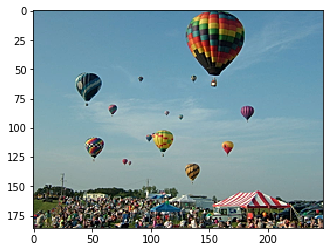

In [6]:
input_img = glob.glob('./image/balloon_origin.png')
sample = cv2.cvtColor(cv2.imread(input_img[0]), cv2.COLOR_BGR2RGB)
img_size = np.shape(sample)
img_size_set = []

img_N = []
for i in range(num_scale):
    img_N.append(cv2.resize(sample, (int(img_size[1]*(scale**i)), int(img_size[0]*(scale**i)))))
    img_size_set.append(np.shape(img_N[i]))
    
plt.imshow(img_N[0])
img_N = img_norm(np.array(img_N))[::-1]
img_size_set = img_size_set[::-1]

## Model

In [8]:
class SinGAN():
    def __init__(self):
        # GPU 메모리 증가 허용
        config = tf.ConfigProto()
        # 실행 과정에서 요구되는 만큼의 GPU 메모리만 할당하게 함
        config.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=config)
        self.GAN()
        
    def conv_block(self, inp, n_filter, n_kernel, norm, act, i):
        conv = tf.layers.conv2d(inp, filters=n_filter, kernel_size=n_kernel, strides=1, padding="SAME", name="conv_"+i,
                                kernel_initializer=tf.initializers.glorot_uniform())
        # batch 정규화 : batch 단위로 정규화
        if norm == "B":
            conv = tf.layers.batch_normalization(conv)
        # 구현 시 배치 정규화를 사용하는 것이 이상해 instance 정규화 사용
        elif norm == "I":
            conv = tf.contrib.layers.instance_norm(conv)
            
        if act == "L":
            conv = tf.nn.leaky_relu(conv)
        elif act == "T":
            conv = tf.nn.tanh(conv)
            
        return conv

    def generator(self, img, noise, n_filter, net_name):
        # noise 입력받아 가짜 이미지 생성 (Residual 구조)
        # 커널 수만 다르고 연산자는 같아 동일한 receptive field 가짐. 생성하는 image 크기만 다르다
        # 각 구조는 3*3 Conv -> BatchNorm -> LeakyReLU를 5번 반복한 fully connected 구조
        inp = img + noise
        with tf.variable_scope(net_name, reuse=tf.AUTO_REUSE):
            conv1 = self.conv_block(inp, n_filter*8, 3, "I", "L", "1")
            conv2 = self.conv_block(conv1, n_filter*4, 3, "I", "L", "2")
            conv3 = self.conv_block(conv2, n_filter*2, 3, "I", "L", "3")
            conv4 = self.conv_block(conv3, n_filter, 3, "I", "L", "4")
            
            ## Receptive field 크기 11x11
            img_gen = self.conv_block(conv4, 3, 3, "I", "T", "5")
            out = img_gen + img
        return out

    def discriminator(self, img, n_filter, net_name):
        with tf.variable_scope(net_name, reuse=tf.AUTO_REUSE):
            conv1 = self.conv_block(img, n_filter*1, 3, "B", "L", "1")
            conv2 = self.conv_block(conv1, n_filter*2, 3, "B", "L", "2")
            conv3 = self.conv_block(conv2, n_filter*4, 3, "B", "L", "3")
            conv4 = self.conv_block(conv3, n_filter*8, 3, "B", "L", "4")
            conv5 = self.conv_block(conv4, 1, 3, "", "", "5")
            
            ## Receptive field size is 11x11
            # 결과 평균 내 사용
            logit = tf.reduce_mean(conv5)
        return logit
    
    def adv_loss(self, real, fake, D_real, D_fake, n_filter, scale):
        # Adversarial loss 
        # WGAN-GP Loss
        eps = tf.random_uniform(shape=tf.shape(real),minval=0.0, maxval=1.0)
        x_hat = (eps * real) + ((1-eps) * fake)
        D_hat = self.discriminator(x_hat, n_filter, "dis_" + str(scale))
        grad = tf.gradients(D_hat, [x_hat])[0]
        GP = D_lambda * tf.square(tf.norm(grad, ord=2) - 1)
        
        D_loss = D_fake - D_real + GP
        G_loss = - D_fake
        return G_loss, D_loss
        
    def rec_loss(self, real, fake):
        # Reconstruction loss
        # 생성한 이미지와 원래의 이미지 간의 차이를 줄이는 방향으로 학습하기 위함
        # MSE Loss
        G_loss = tf.reduce_mean(tf.square(real - fake))
        return G_loss
        
    def GAN(self):
        self.learning_rate = tf.placeholder(shape=[], dtype=tf.float32)
        self.is_train = tf.placeholder(dtype=tf.bool)
        
        self.inp = {}
        self.noise = {}
        self.inp_fix = {}
        self.noise_fix = {}
        self.real = {}
        self.fake = {}
        self.fake_fix = {}
        self.real_D = {}
        self.fake_D = {}
        
        self.loss_gen = {}
        self.loss_dis = {}

        for i in range(num_scale):
            self.inp[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            self.inp_fix[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            
            self.noise[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            self.noise_fix[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)
            
            self.real[str(i)] = tf.placeholder(shape=[batch_size,None,None,3], dtype=tf.float32)

            self.fake[str(i)] = self.generator(self.inp[str(i)], self.noise[str(i)], filters[i], "gen_" + str(i))
            self.fake_fix[str(i)] = self.generator(self.inp_fix[str(i)], self.noise_fix[str(i)], filters[i], "gen_" + str(i))
            
            self.real_D[str(i)] = self.discriminator(self.real[str(i)], filters[i], "dis_" + str(i))
            self.fake_D[str(i)] = self.discriminator(self.fake[str(i)], filters[i], "dis_" + str(i))
      
            adv_gen, adv_dis = self.adv_loss(self.real[str(i)], self.fake[str(i)],
                                             self.real_D[str(i)], self.fake_D[str(i)],
                                             filters[i], i)
        
            rec_gen = self.rec_loss(self.real[str(i)], self.fake_fix[str(i)])

            self.loss_gen[str(i)] = L_adv*adv_gen + L_rec*rec_gen
            self.loss_dis[str(i)] = L_adv*adv_dis
            
        self.var_all = tf.trainable_variables()
        self.var_gen = {}
        self.var_dis = {}
        self.opt_gen = {}
        self.opt_dis = {}
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        for i in range(num_scale):
            self.var_gen[str(i)] = [var for var in self.var_all if "gen_" + str(i) in var.name]
            self.var_dis[str(i)] = [var for var in self.var_all if "dis_" + str(i) in var.name]
            
            opt_gen = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.5, beta2=0.999)
            opt_dis = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta1=0.5, beta2=0.999)
            
            with tf.control_dependencies(update_ops):
                self.opt_gen[str(i)] = opt_gen.minimize(self.loss_gen[str(i)], var_list=self.var_gen[str(i)])
                self.opt_dis[str(i)] = opt_dis.minimize(self.loss_dis[str(i)], var_list=self.var_dis[str(i)])

## Initialization

In [9]:
# 초기화
network = SinGAN()
init = tf.global_variables_initializer()
network.sess.run(init)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


## Train

Scale: 0 / Epoch: 250 / G Loss: 18.22862 / D Loss: -11.61261


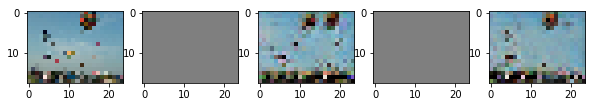

Scale: 0 / Epoch: 500 / G Loss: 50.84963 / D Loss: -16.76451


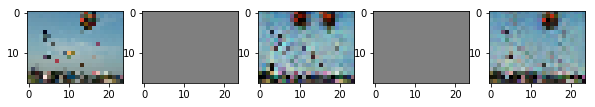

Scale: 0 / Epoch: 750 / G Loss: 44.43556 / D Loss: -21.88422


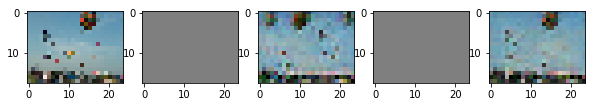

Scale: 0 / Epoch: 1000 / G Loss: 63.22928 / D Loss: -22.75554


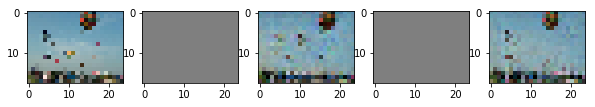

Scale: 0 / Epoch: 1250 / G Loss: 48.15950 / D Loss: -24.08826


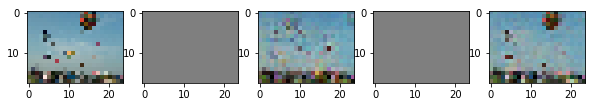

Scale: 0 / Epoch: 1500 / G Loss: 56.82211 / D Loss: -21.18659


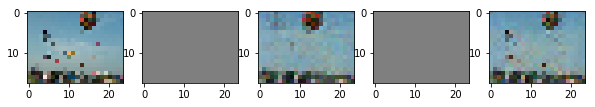

Scale: 0 / Epoch: 1750 / G Loss: 75.36594 / D Loss: -18.94535


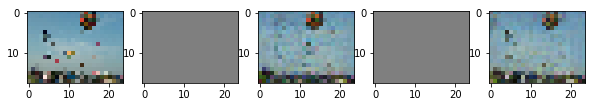

Scale: 0 / Epoch: 2000 / G Loss: 70.87512 / D Loss: -23.02160


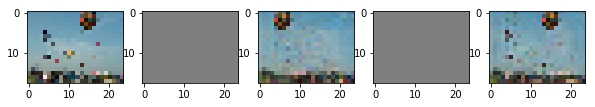

Assignment is finished!
Scale: 1 / Epoch: 250 / G Loss: 274.69928 / D Loss: -20.16083


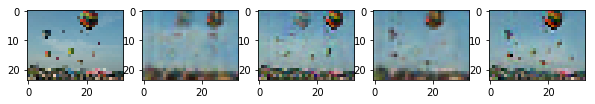

Scale: 1 / Epoch: 500 / G Loss: 279.61462 / D Loss: -18.02309


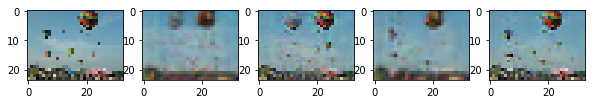

Scale: 1 / Epoch: 750 / G Loss: 295.19055 / D Loss: -23.65755


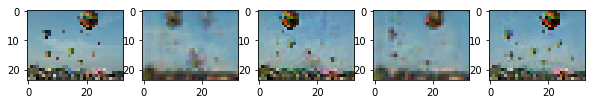

Scale: 1 / Epoch: 1000 / G Loss: 280.81299 / D Loss: -23.70520


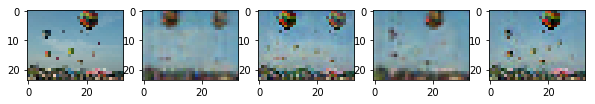

Scale: 1 / Epoch: 1250 / G Loss: 287.13611 / D Loss: -19.32104


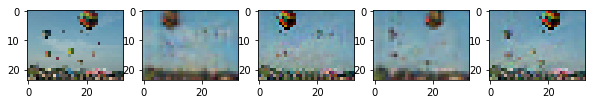

Scale: 1 / Epoch: 1500 / G Loss: 257.98871 / D Loss: -28.24311


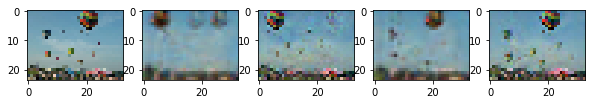

Scale: 1 / Epoch: 1750 / G Loss: 249.95738 / D Loss: -20.49067


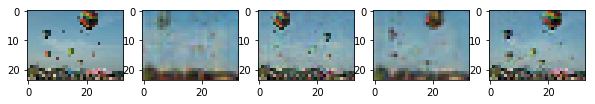

Scale: 1 / Epoch: 2000 / G Loss: 231.53418 / D Loss: -18.75735


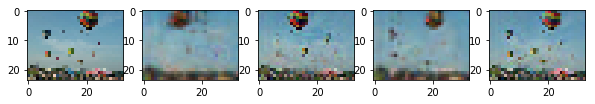

Assignment is finished!
Scale: 2 / Epoch: 250 / G Loss: 361.73148 / D Loss: -31.73018


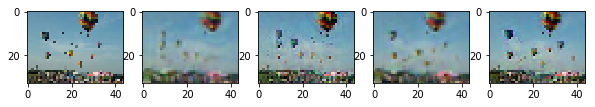

Scale: 2 / Epoch: 500 / G Loss: 351.55096 / D Loss: -30.35697


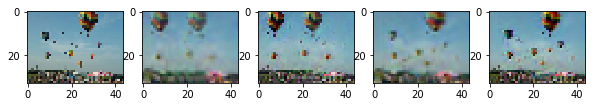

Scale: 2 / Epoch: 750 / G Loss: 325.27377 / D Loss: -30.75107


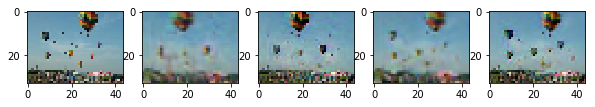

Scale: 2 / Epoch: 1000 / G Loss: 361.47314 / D Loss: -35.91863


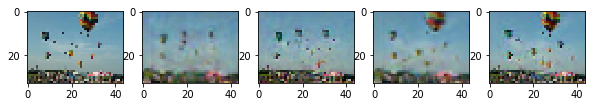

Scale: 2 / Epoch: 1250 / G Loss: 413.93613 / D Loss: -31.13882


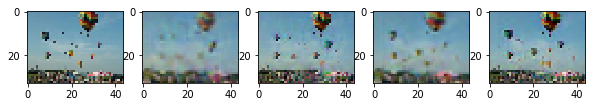

Scale: 2 / Epoch: 1500 / G Loss: 331.03760 / D Loss: -30.45981


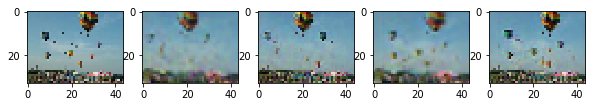

Scale: 2 / Epoch: 1750 / G Loss: 352.37036 / D Loss: -44.00177


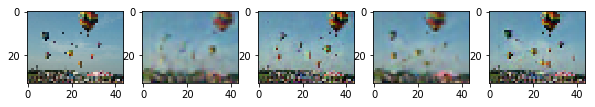

Scale: 2 / Epoch: 2000 / G Loss: 246.22429 / D Loss: -29.57362


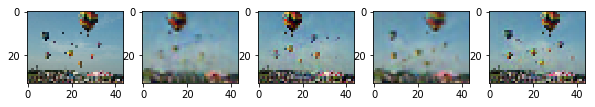

Assignment is finished!
Scale: 3 / Epoch: 250 / G Loss: 334.20508 / D Loss: -37.20260


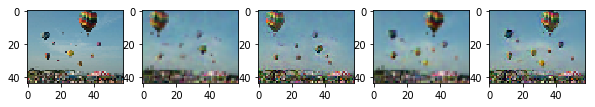

Scale: 3 / Epoch: 500 / G Loss: 315.02597 / D Loss: -51.28358


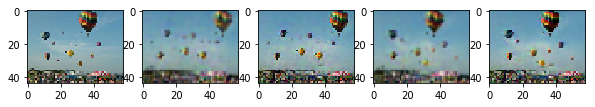

Scale: 3 / Epoch: 750 / G Loss: 426.76608 / D Loss: -59.09803


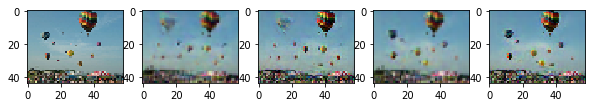

Scale: 3 / Epoch: 1000 / G Loss: 429.39496 / D Loss: -51.52267


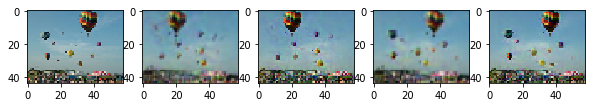

Scale: 3 / Epoch: 1250 / G Loss: 424.31213 / D Loss: -42.88470


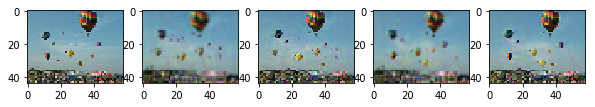

Scale: 3 / Epoch: 1500 / G Loss: 472.60889 / D Loss: -56.38114


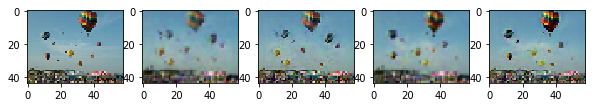

Scale: 3 / Epoch: 1750 / G Loss: 460.59128 / D Loss: -58.15333


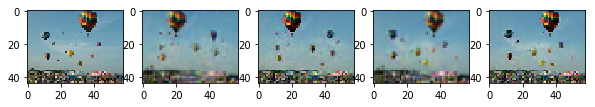

Scale: 3 / Epoch: 2000 / G Loss: 458.36728 / D Loss: -72.23380


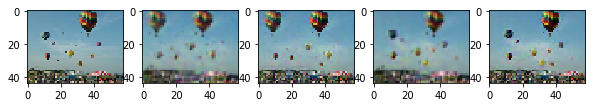

Assignment is finished!
Scale: 4 / Epoch: 250 / G Loss: 339.63159 / D Loss: -55.16493


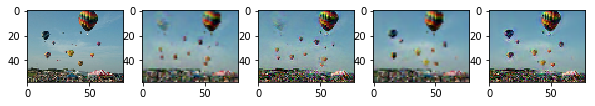

Scale: 4 / Epoch: 500 / G Loss: 534.04547 / D Loss: -57.53809


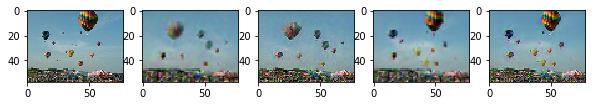

Scale: 4 / Epoch: 750 / G Loss: 479.64755 / D Loss: -53.53988


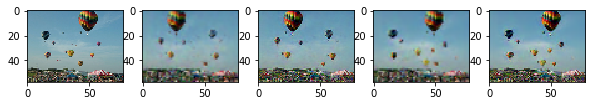

Scale: 4 / Epoch: 1000 / G Loss: 480.24991 / D Loss: -54.03978


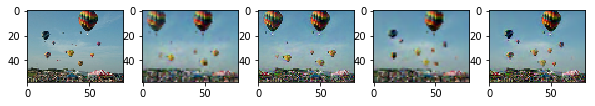

Scale: 4 / Epoch: 1250 / G Loss: 552.17218 / D Loss: -78.96017


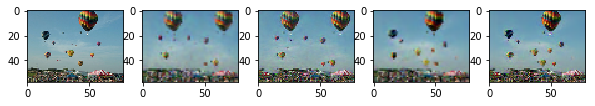

Scale: 4 / Epoch: 1500 / G Loss: 516.45618 / D Loss: -57.97896


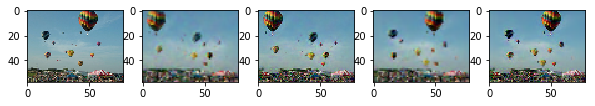

Scale: 4 / Epoch: 1750 / G Loss: 574.68469 / D Loss: -77.06913


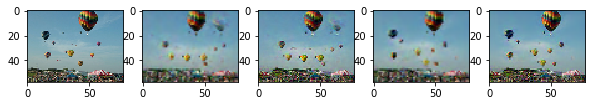

Scale: 4 / Epoch: 2000 / G Loss: 524.79767 / D Loss: -70.62711


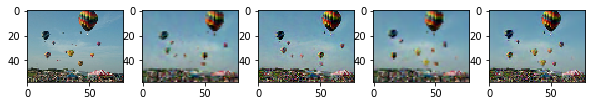

Assignment is finished!
Scale: 5 / Epoch: 250 / G Loss: 411.15564 / D Loss: -80.72528


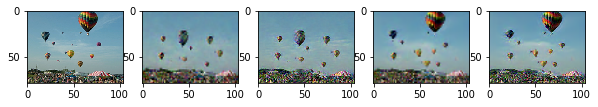

Scale: 5 / Epoch: 500 / G Loss: 484.72144 / D Loss: -95.57498


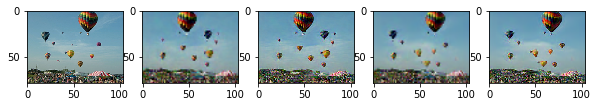

Scale: 5 / Epoch: 750 / G Loss: 624.08246 / D Loss: -72.26945


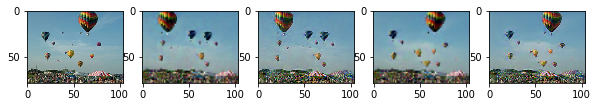

Scale: 5 / Epoch: 1000 / G Loss: 648.69635 / D Loss: -104.96225


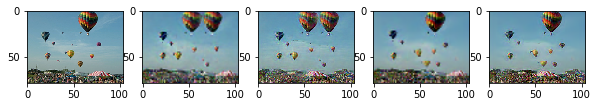

Scale: 5 / Epoch: 1250 / G Loss: 586.46252 / D Loss: -79.30267


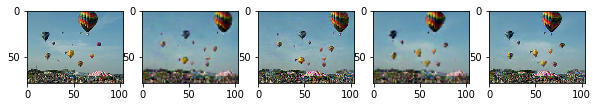

Scale: 5 / Epoch: 1500 / G Loss: 644.04340 / D Loss: -97.90243


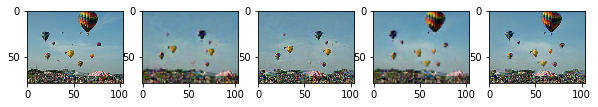

Scale: 5 / Epoch: 1750 / G Loss: 603.93842 / D Loss: -106.12024


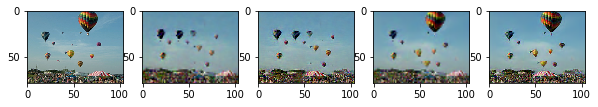

Scale: 5 / Epoch: 2000 / G Loss: 623.65271 / D Loss: -121.43961


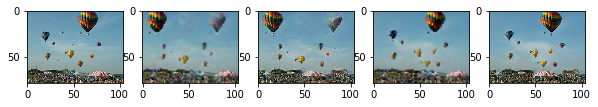

Assignment is finished!
Scale: 6 / Epoch: 250 / G Loss: 651.39667 / D Loss: -68.68063


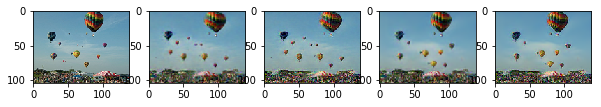

Scale: 6 / Epoch: 500 / G Loss: 626.97046 / D Loss: -83.15401


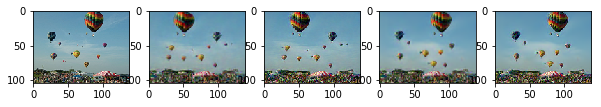

Scale: 6 / Epoch: 750 / G Loss: 758.82141 / D Loss: -111.84472


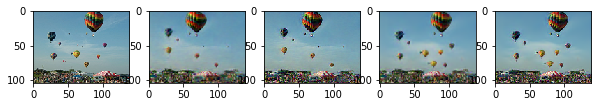

Scale: 6 / Epoch: 1000 / G Loss: 714.54553 / D Loss: -143.22717


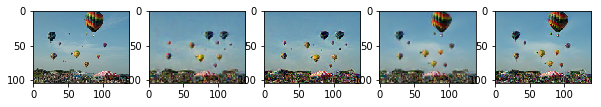

Scale: 6 / Epoch: 1250 / G Loss: 805.90820 / D Loss: -124.01492


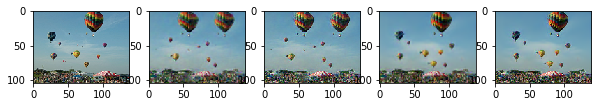

Scale: 6 / Epoch: 1500 / G Loss: 888.12787 / D Loss: -130.38852


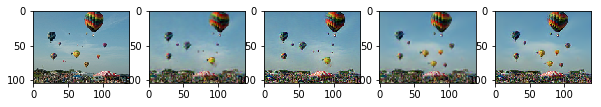

Scale: 6 / Epoch: 1750 / G Loss: 842.39148 / D Loss: -171.69852


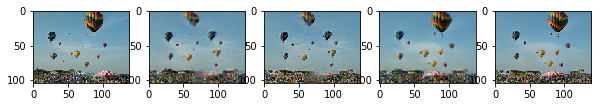

Scale: 6 / Epoch: 2000 / G Loss: 834.89569 / D Loss: -145.56148


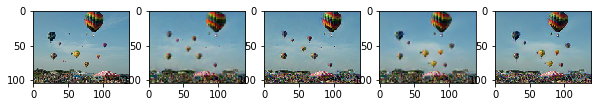

Assignment is finished!
Scale: 7 / Epoch: 250 / G Loss: 438.84561 / D Loss: -64.01357


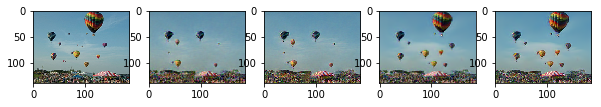

Scale: 7 / Epoch: 500 / G Loss: 324.81973 / D Loss: -74.14454


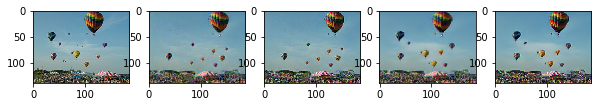

Scale: 7 / Epoch: 750 / G Loss: 513.30615 / D Loss: -85.83805


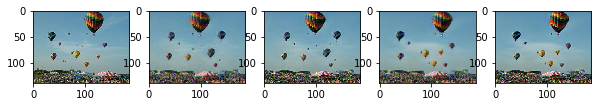

Scale: 7 / Epoch: 1000 / G Loss: 712.26831 / D Loss: -98.55029


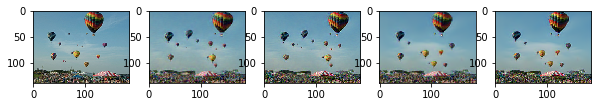

Scale: 7 / Epoch: 1250 / G Loss: 590.31561 / D Loss: -118.60463


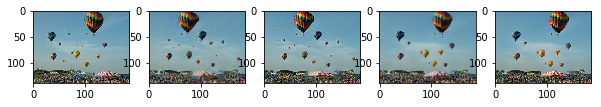

Scale: 7 / Epoch: 1500 / G Loss: 707.69562 / D Loss: -121.58439


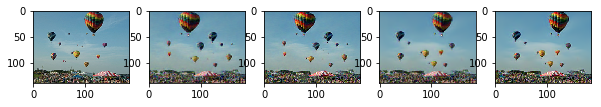

Scale: 7 / Epoch: 1750 / G Loss: 712.09253 / D Loss: -130.56415


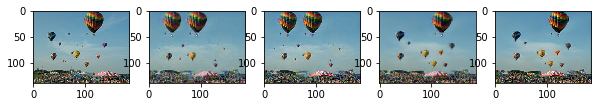

Scale: 7 / Epoch: 2000 / G Loss: 718.24060 / D Loss: -145.34305


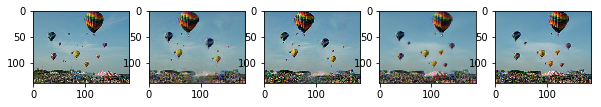

Assignment is finished!
Scale: 8 / Epoch: 250 / G Loss: 559.34705 / D Loss: -45.17035


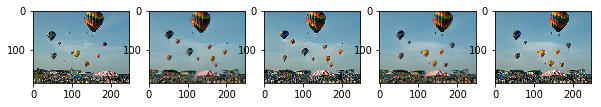

Scale: 8 / Epoch: 500 / G Loss: 893.39612 / D Loss: -93.65739


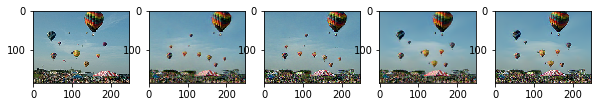

Scale: 8 / Epoch: 750 / G Loss: 1150.87036 / D Loss: -197.38933


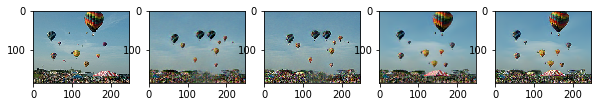

Scale: 8 / Epoch: 1000 / G Loss: 891.34607 / D Loss: -162.51329


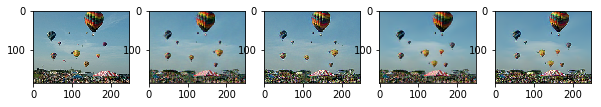

Scale: 8 / Epoch: 1250 / G Loss: 1153.72205 / D Loss: -159.05254


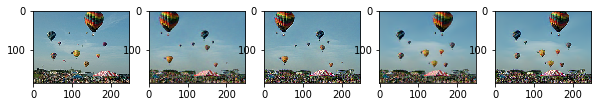

Scale: 8 / Epoch: 1500 / G Loss: 848.18829 / D Loss: -252.83473


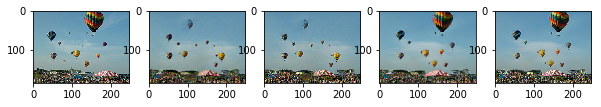

Scale: 8 / Epoch: 1750 / G Loss: 1154.04871 / D Loss: -184.63312


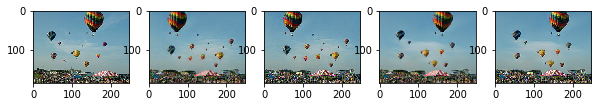

Scale: 8 / Epoch: 2000 / G Loss: 1296.39539 / D Loss: -205.88631


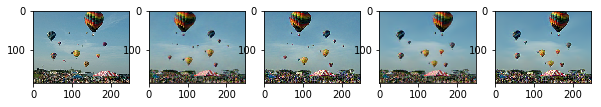

In [11]:
set_noise = noise_fix(img_size_set)

iteration = 0
for i in range(num_scale):
    for j in range(num_epoch[i]):
        if (i != 0) and (j == 0):
            if filters[i] == filters[i-1]:
                for k in range(len(network.var_gen[str(i)])):
                    network.sess.run(network.var_gen[str(i)][k].assign(network.var_gen[str(i-1)][k]))
                for k in range(len(network.var_dis[str(i)])):
                    network.sess.run(network.var_dis[str(i)][k].assign(network.var_dis[str(i-1)][k]))
                print("Assignment is finished!")

        if (i != 0):
            learning_rate = learning_rate*0.99995

        feed_dict = {network.learning_rate: learning_rate,
                     network.inp[str(0)]: [np.zeros(img_size_set[0])],
                     network.noise[str(0)]: img_noise(img_size_set[0]),
                     network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
                     network.noise_fix[str(0)]: set_noise[0],
                     network.real[str(0)]: [img_N[0]]}

        for k in range(i):
            fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                              feed_dict = feed_dict)
            feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
            feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])

            feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
            feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
            feed_dict[network.real[str(k+1)]] = [img_N[k+1]]

        for _ in range(iter_grad):
            _, loss_gen = network.sess.run([network.opt_gen[str(i)], network.loss_gen[str(i)]],
                                           feed_dict=feed_dict)
        for _ in range(iter_grad):    
            _, loss_dis = network.sess.run([network.opt_dis[str(i)], network.loss_dis[str(i)]],
                                           feed_dict=feed_dict)

        fake, inp = network.sess.run([network.fake[str(i)], network.inp[str(i)]], feed_dict=feed_dict)
        fake_fix, inp_fix = network.sess.run([network.fake_fix[str(i)], network.inp_fix[str(i)]], feed_dict=feed_dict)
        fake = denorm(fake)
        inp = denorm(inp)
        fake_fix = denorm(fake_fix)
        inp_fix = denorm(inp_fix)

        if j % 250 == 249:
            print("Scale: {} / Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i) ,(j+1), loss_gen, loss_dis))
            fig, ax = plt.subplots(1,5, figsize=[10,50])
            ax[0].imshow(denorm(img_N[i]))
            ax[1].imshow(inp[0])
            ax[2].imshow(fake[0])
            ax[3].imshow(inp_fix[0])
            ax[4].imshow(fake_fix[0])
            plt.show()
        iteration += 1

## Test

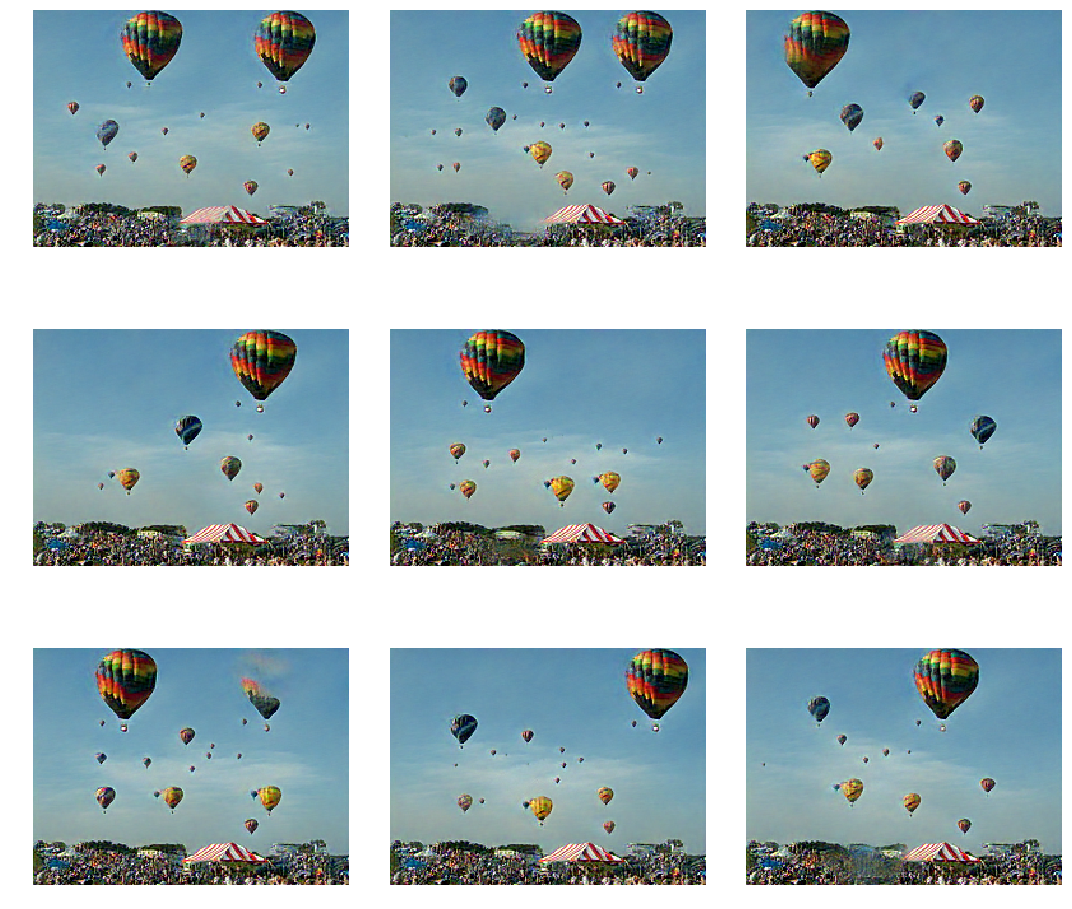

In [13]:
fig, ax = plt.subplots(3,3, figsize=[15,15])
for i in range(9):
    feed_dict = {network.inp[str(0)]: [np.zeros(img_size_set[0])],
                 network.noise[str(0)]: img_noise(img_size_set[0]),
                 network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
                 network.noise_fix[str(0)]: set_noise[0],
                 network.real[str(0)]: [img_N[0]]}

    for k in range(num_scale - 1):
        fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                          feed_dict = feed_dict)
        feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
        feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])
        feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
        feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
        feed_dict[network.real[str(k+1)]] = [img_N[k+1]]

    fake, inp = network.sess.run([network.fake[str(num_scale-1)], network.inp[str(num_scale-1)]], feed_dict=feed_dict)
    index = [int(i/3), i%3]
    ax[index[0]][index[1]].imshow(denorm(fake[0]))
    ax[index[0]][index[1]].axis('off')
    fig.tight_layout()

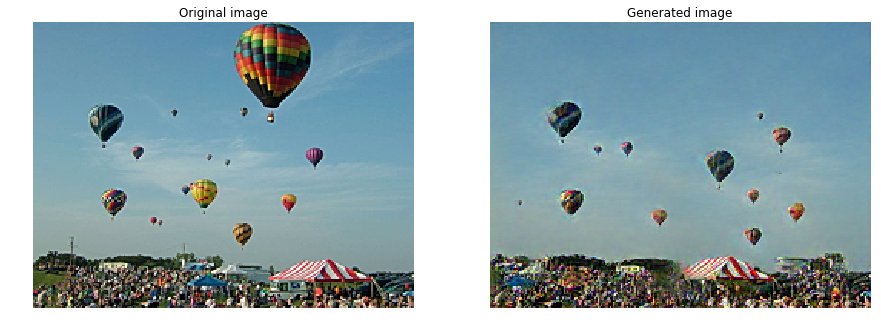

In [14]:
feed_dict = {network.inp[str(0)]: [np.zeros(img_size_set[0])],
             network.noise[str(0)]: img_noise(img_size_set[0]),
             network.inp_fix[str(0)]: [np.zeros(img_size_set[0])],
             network.noise_fix[str(0)]: set_noise[0],
             network.real[str(0)]: [img_N[0]]}
fig, ax = plt.subplots(1,2, figsize=[15,30])
ax[0].imshow((img_N[-1] + 1) / 2)
ax[0].set_title('Original image')
ax[1].set_title('Generated image')
ax[0].axis('off')
ax[1].axis('off')
for k in range(num_scale - 1):
    fake, fake_fix = network.sess.run([network.fake[str(k)], network.fake_fix[str(k)]],
                                      feed_dict = feed_dict)
    feed_dict[network.inp[str(k+1)]] = img_resize(fake[0], img_size_set[k+1])
    feed_dict[network.inp_fix[str(k+1)]] = img_resize(fake_fix[0], img_size_set[k+1])
    feed_dict[network.noise[str(k+1)]] = img_noise(img_size_set[k+1])
    feed_dict[network.noise_fix[str(k+1)]] = set_noise[k+1]
    feed_dict[network.real[str(k+1)]] = [img_N[k+1]]
    
fake, inp = network.sess.run([network.fake[str(num_scale-1)], network.inp[str(num_scale-1)]], feed_dict=feed_dict)
ax[1].imshow(denorm(fake[0]))